<a href="https://colab.research.google.com/github/drscook/m5364_23sp_data_science1/blob/main/pipelines_AirBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q 'git+https://github.com/drscook/helpers'
! pip install -q --upgrade pandas scikit-learn # pandas 2.0 just released on April 6
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


{'status': 'ok', 'restart': True}

In [9]:
%reload_ext autotime
from helpers.common_imports import *
from helpers import utilities as ut
pd.DataFrame.prep = ut.prep  # add prep from my utilities to all dataframes (This is called "monkey patching". It's often considered poor practice compared to subclassing. But I find this one really convenient.)

# ask scikit-learn to give us pands dataframes rather than numpy arrays
from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.datasets import fetch_openml
airbnb = fetch_openml(data_id=43819)
df = airbnb.data.prep().set_index('id')

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<Axes: >

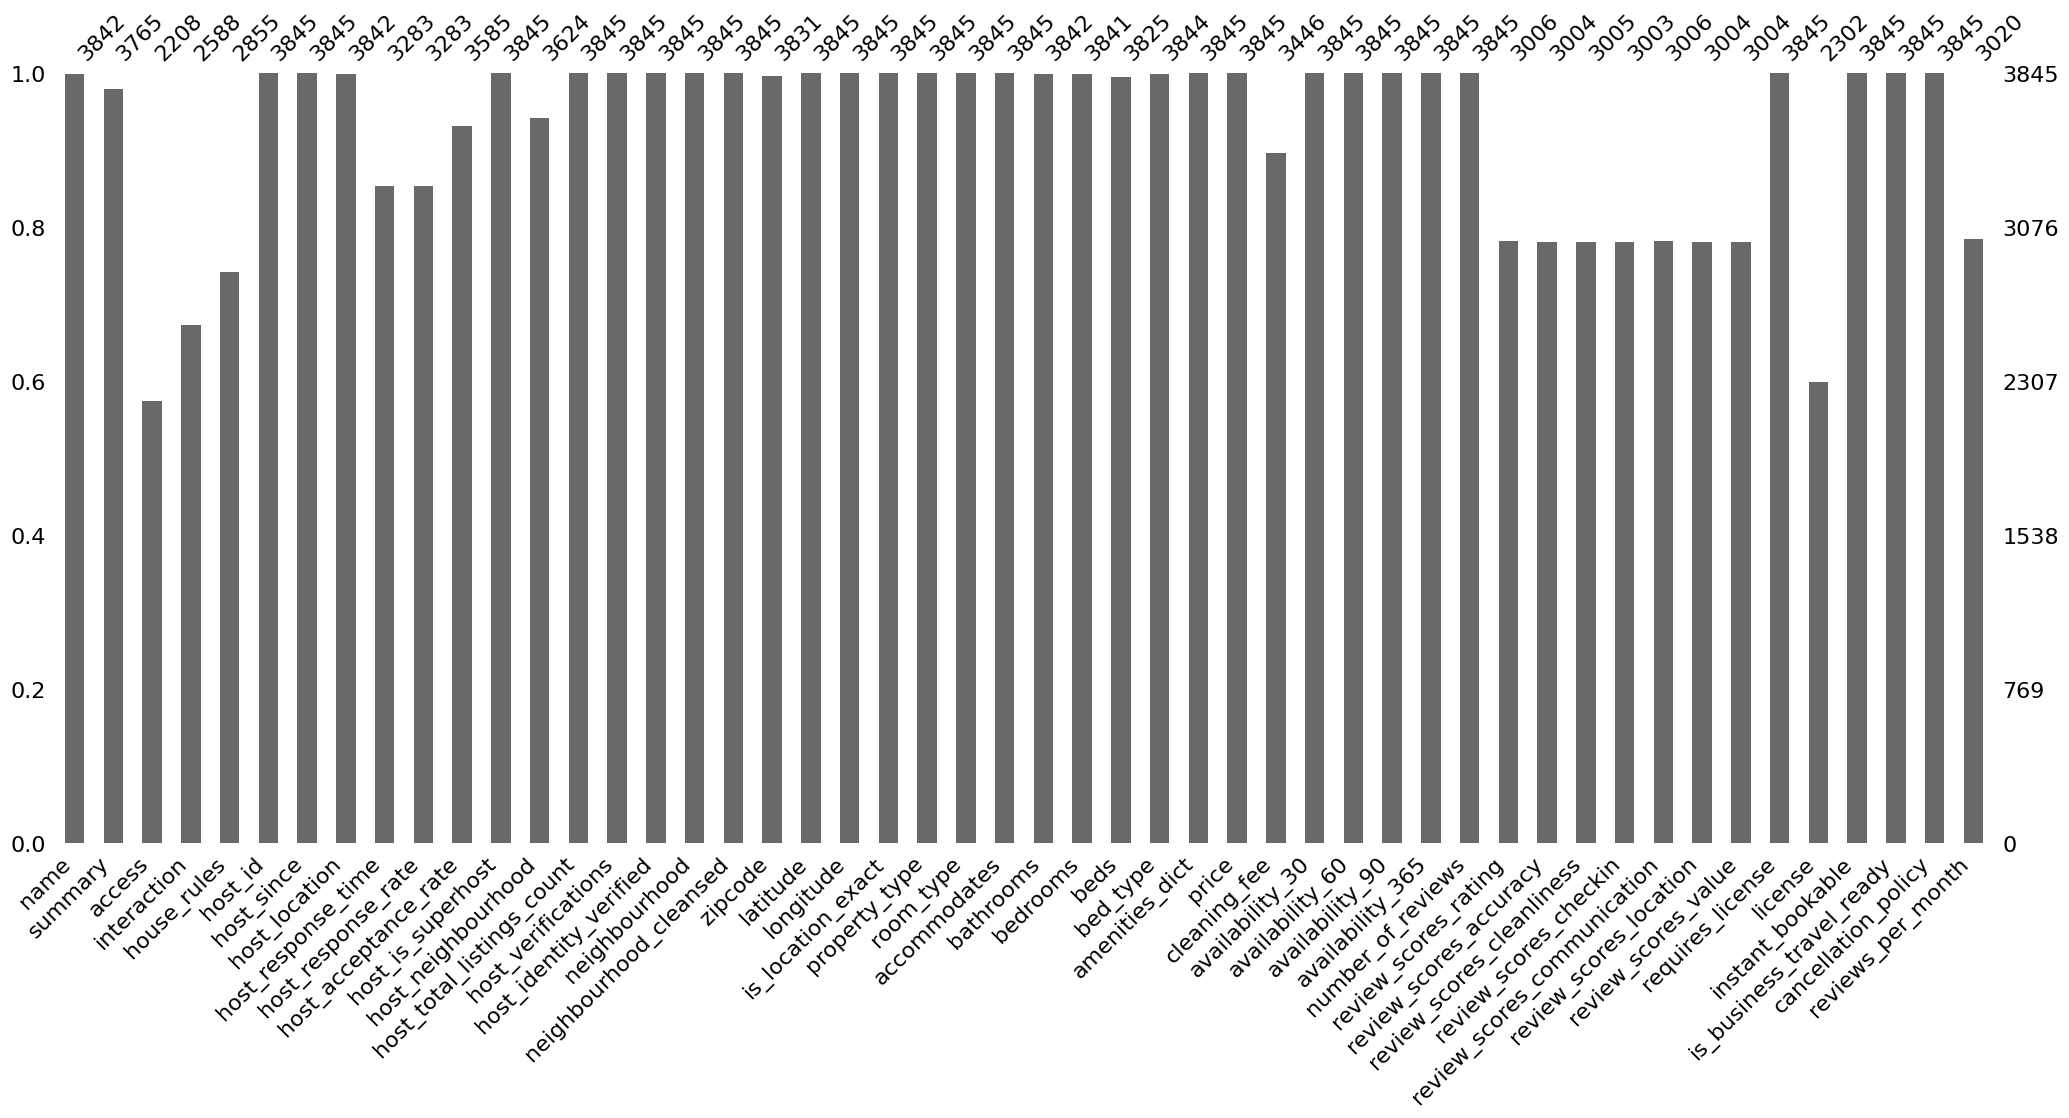

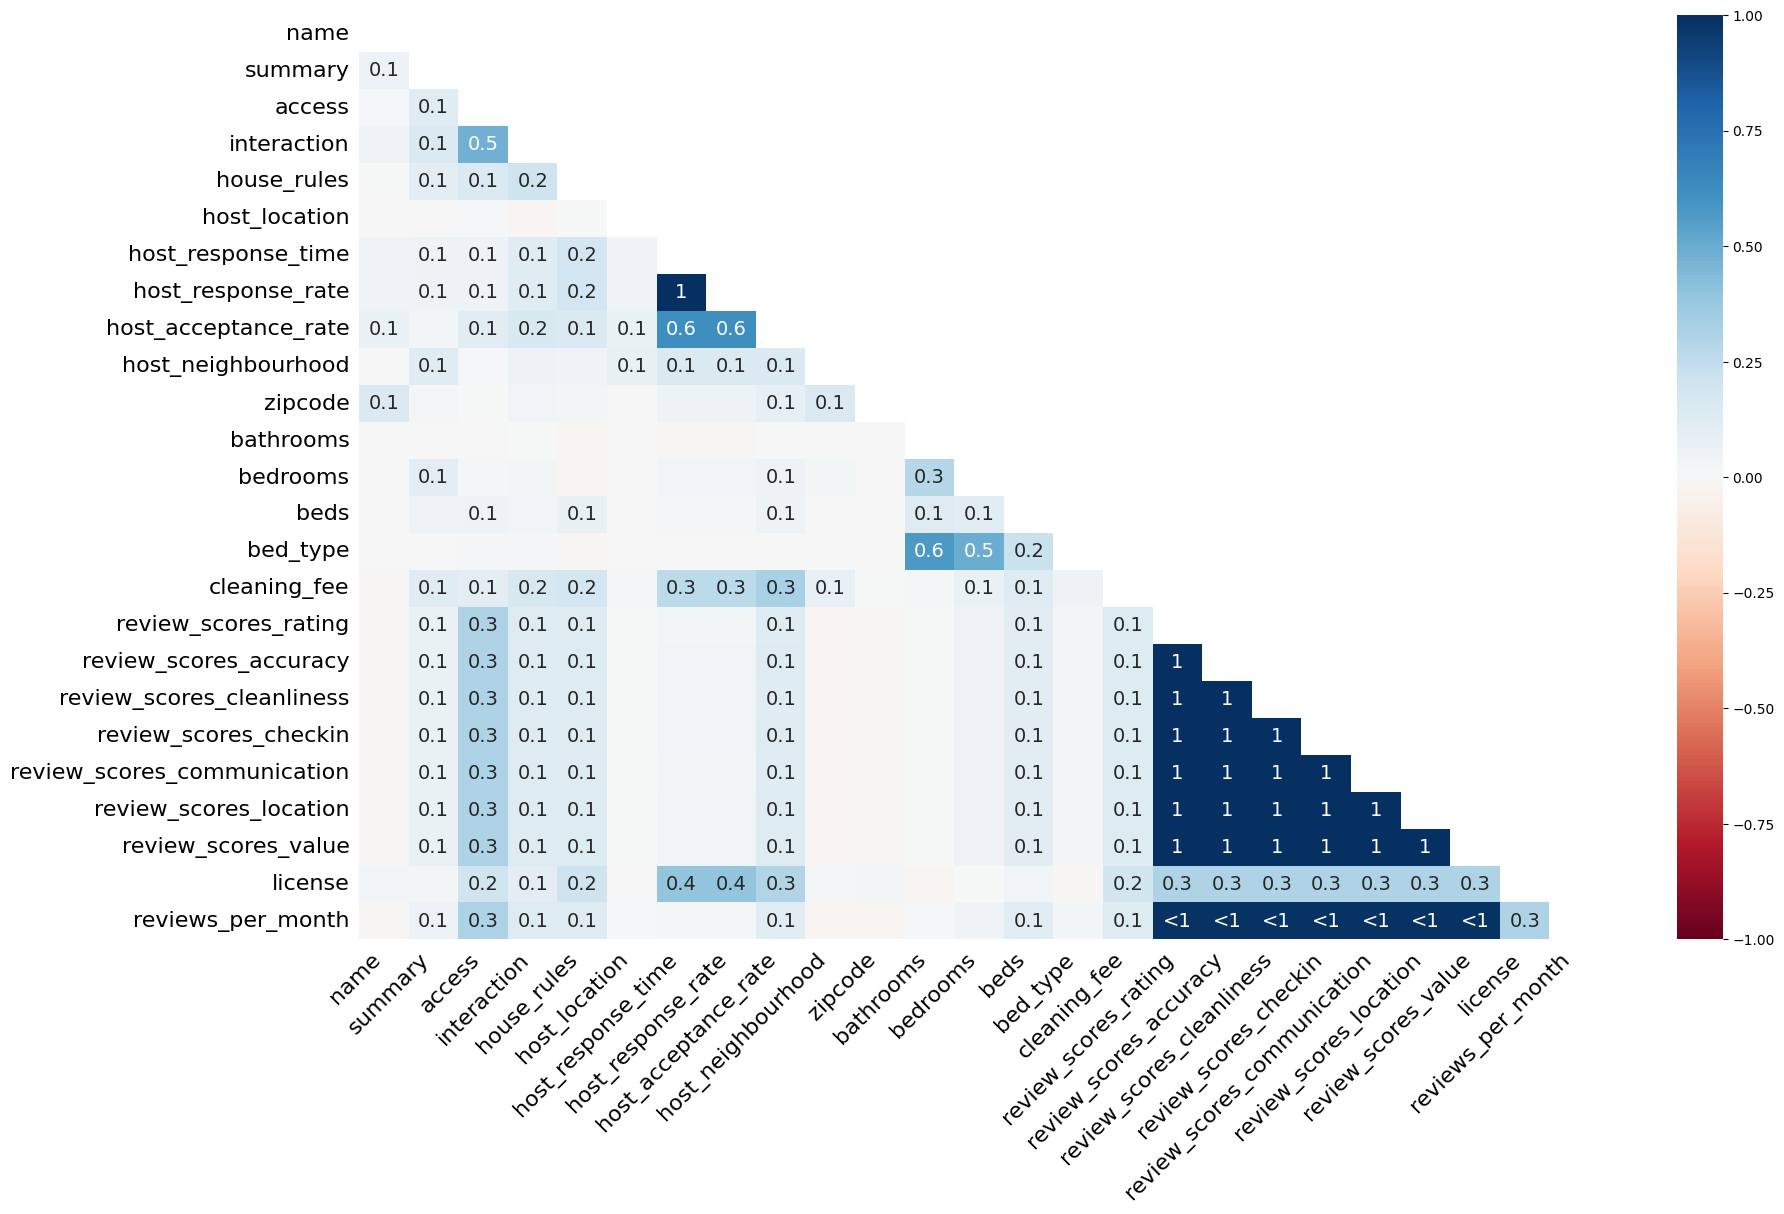

In [10]:
import missingno as msno
msno.bar(df)
msno.heatmap(df)

In [11]:
# lower case all strings
for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass
df['price'] = df['price'].str.replace(',','').astype(float)
df['pets_ok'] = ~df['house_rules'].str.contains('no pets')
df['smoking_ok'] = ~df['house_rules'].str.contains('smok')

# I tried to be more careful with smoking_ok, but there are a lot of different ways to say do not smoke here
# https://stackoverflow.com/questions/48541444/pandas-filtering-for-multiple-substrings-in-series/48600345#48600345
# df['smoking_ok'] = ~df['house_rules'].str.contains('|'.join(['smoking', 'non smoking', 'non-smoking', 'smoking not permitted', 'smoking is not permitted']))

,review_scores_rating,price,bedrooms,bathrooms,cleaning_fee,pets_ok,smoking_ok,amenities_dict,neighbourhood_cleansed
count,3006.0,3006.000000,3005.0,3004.0,2762.0,2324,2324,3006,3006
unique,<NA>,NaN,<NA>,<NA>,<NA>,2,2,2395,25
top,<NA>,NaN,<NA>,<NA>,<NA>,True,False,"'tv': 1, 'cable tv': 0, 'wifi': 1, 'air condit...",dorchester
freq,<NA>,NaN,<NA>,<NA>,<NA>,1982,1334,66,387
mean,93.028942,177.923486,1.321464,1.274467,71.356626,NaN,NaN,NaN,NaN
std,9.156733,376.842072,0.968455,0.515479,57.028729,NaN,NaN,NaN,NaN
min,20.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN
25%,91.0,80.000000,1.0,1.0,30.0,NaN,NaN,NaN,NaN
50%,96.0,133.000000,1.0,1.0,60.0,NaN,NaN,NaN,NaN
75%,99.0,199.000000,2.0,1.5,100.0,NaN,NaN,NaN,NaN


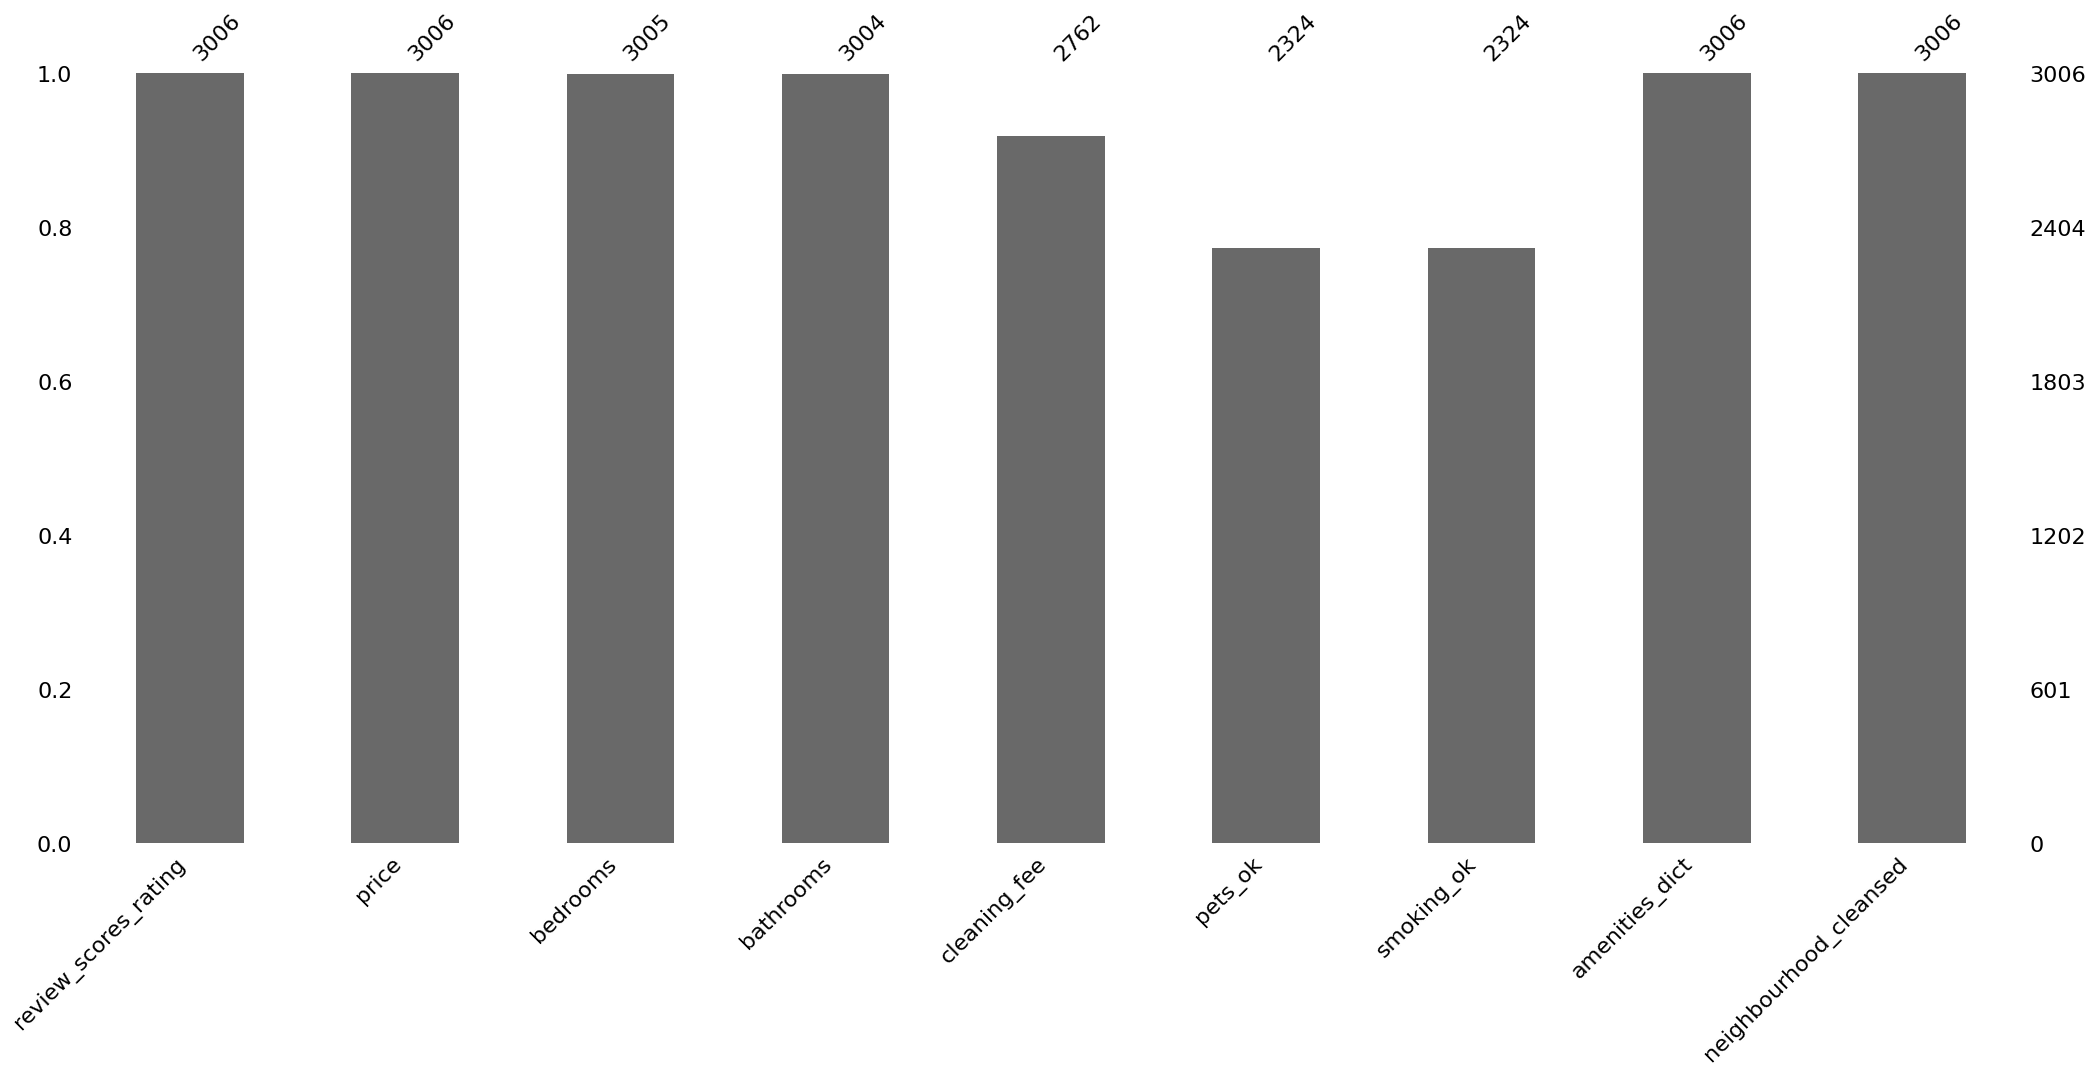

In [12]:
targ = 'review_scores_rating'
feat = [
    'price',
    'bedrooms',
    'bathrooms',
    'cleaning_fee',
    'pets_ok',
    'smoking_ok',
    'amenities_dict',
    'neighbourhood_cleansed',
]
all = [targ, *feat]
mask = df[targ].notnull()
df_all = df.loc[mask, all]

msno.bar(df_all)
display(df_all.describe(include='all'))
X = df_all[feat].copy()
y = df_all[targ].copy()

In [13]:
df[df['price']<10]

,name,summary,access,interaction,house_rules,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities_dict,price,cleaning_fee,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month,pets_ok,smoking_ok
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20349970,"walk to the beach or city, room 7",this private room is centrally connected to th...,access to the kitchen and bathroom.,we live upstairs but are always available by t...,-do not auto book if you live in eastern massa...,30342817,2015-03-31,"boston, massachusetts, united states",within an hour,88,99,f,dorchester,7,"['email', 'phone', 'facebook', 'reviews', 'jum...",f,dorchester,dorchester,2125,42.32082,-71.05502,t,house,private room,3,2.0,1,1,real bed,"'tv': 0, 'cable tv': 0, 'wifi': 1, 'air condit...",0.0,45,28,58,88,353,97,87,9,9,9,9,9,9,t,str-414419,f,f,strict_14_with_grace_period,3.09,True,False
41645764,(h5) modern- near old north church,stay healthy with us! with all the craziness g...,<NA>,i am available through airbnb messenger monday...,host needs prior notice if extra linens or bab...,328488585,2020-01-17,us,within an hour,98,100,f,north end,0,"['email', 'phone']",f,north end,north end,2113,42.36615,-71.05454,t,apartment,entire home/apt,2,1.0,1,1,real bed,"'tv': 1, 'cable tv': 0, 'wifi': 1, 'air condit...",0.0,65,28,58,88,131,10,96,10,10,9,10,10,9,t,exempt: this listing is a unit that has contra...,t,f,strict_14_with_grace_period,3.61,True,False
42065558,boston fenway inn,the focus on minimalist design and economical ...,<NA>,<NA>,free shuttle service offered (5-minute walking...,308490585,2019-11-10,"boston, massachusetts, united states",within an hour,100,100,f,fenway/kenmore,0,"['email', 'phone', 'work_email']",f,fenway/kenmore,fenway,2115,42.34637,-71.08882,t,hostel,hotel room,1,<NA>,<NA>,<NA>,<NA>,"'tv': 0, 'cable tv': 0, 'wifi': 1, 'air condit...",0.0,<NA>,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,t,exempt: this listing is a hotel or motel,f,f,moderate,<NA>,True,True


In [14]:
from sklearn.preprocessing import OneHotEncoder

# extract amenities into indicator columns
A = X['amenities_dict'].str.split(', ', expand=True)  # split pieces of amentities string into separate columns
A.columns = [x.split(':')[0].strip("'") for x in A.iloc[0]]  # assign columns names using row 0
A = A.apply(lambda x:x.str[-1] == '1').astype('boolean').prep()  # replace with True if the final character is 1

# can we use the neighborhood column?
enc = OneHotEncoder(sparse_output=False)  # one-hot encoder object
N = enc.fit_transform(X[['neighbourhood_cleansed']]).astype('boolean').prep()  # apply object to neighborhood_cleansed column
N.columns = N.columns.str[23:]  # assigns columns names of the form "neighborhood_cleansed_neighborhood name". It's often useful to have the original column name first, but not here. So we remove it.
X = X.join(N).join(A).drop(columns=['amenities_dict', 'neighbourhood_cleansed']).prep()  # join and drop original columns

In [15]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

amenity_feat = A.columns
amenity_preproc = Pipeline(
    steps=[
        ('pca', PCA(n_components=5))
    ]
)

numeric_feat = ['price', 'bedrooms', 'bathrooms', 'cleaning_fee', 'pets_ok', 'smoking_ok']
# X[numeric_feat] = X[numeric_feat].astype(float)
numeric_preproc = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        # ('scaler', QuantileTransformer),
        ('imputer', KNNImputer()),
    ]
)

preproc = ColumnTransformer(
    transformers = [
        ('amenities', amenity_preproc, amenity_feat),
        ('numeric', numeric_preproc, numeric_feat),
    ],
)
preproc.fit_transform(X)

,amenities__pca0,amenities__pca1,amenities__pca2,amenities__pca3,amenities__pca4,numeric__price,numeric__bedrooms,numeric__bathrooms,numeric__cleaning_fee,numeric__pets_ok,numeric__smoking_ok
id,,,,,,,,,,,
3781,-1.118112,-0.057515,-0.543723,1.037089,-0.221636,0.0125,0.076923,0.166667,0.15,0.0,0.0
5506,-0.536704,0.544832,1.603848,0.043554,0.353504,0.0145,0.076923,0.166667,0.12,1.0,0.0
6695,-1.241433,-0.548058,0.062740,-0.053326,0.117853,0.0169,0.076923,0.166667,0.16,1.0,0.0
8789,-0.281272,-0.931996,-0.333183,0.404923,0.193579,0.0099,0.076923,0.166667,0.50,0.8,0.6
10730,0.236477,-0.992309,0.323315,0.394464,0.524900,0.0150,0.076923,0.166667,0.50,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
42930384,-1.522225,-0.428728,-0.154348,-1.037148,-0.270243,0.0299,0.076923,0.166667,0.14,1.0,0.0
42938680,-1.007868,0.739133,0.533658,0.499180,-0.777299,0.0099,0.230769,0.333333,0.35,0.0,0.0
42966566,-1.538000,-0.133010,-0.065036,-1.010857,-0.330026,0.0299,0.000000,0.166667,0.14,1.0,0.0


In [8]:
preproc

ColumnTransformer(transformers=[('amenities',
                                 Pipeline(steps=[('pca', PCA(n_components=5))]),
                                 Index(['tv', 'cable_tv', 'wifi', 'air_conditioning', 'kitchen',
       'free_parking_on_premises', 'free_street_parking', 'heating', 'washer',
       'dryer',
       ...
       'bath_towel', 'toilet_paper', 'safe', 'bedroom_comforts',
       'bathroom_essentials', 'game_room', 'luggage_storage', 'front_desk',
       'self_parking', 'concierge'],
      dtype='object', length=133)),
                                ('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                                 ('imputer', KNNImputer())]),
                                 ['price', 'bedrooms', 'bathrooms',
                                  'cleaning_fee', 'pets_ok', 'smoking_ok'])])